In [547]:
from sklearn.cluster import KMeans
import pandas as pd
import talib as ta
import numpy as np
from sklearn.base import BaseEstimator

In [548]:
def calc_divergence(df: pd.DataFrame, window=5, pre=3):
    """计算背离"""
    # 顶背离（价格新高但MACD未新高）
    df['price_peak'] = df['close'].rolling(window, center=True).max() == df['close']
    df['macd_peak'] = df['MACD'].rolling(window, center=True).max() == df['MACD']
    # 顶背离（价格新高但MACD未新高）
    df['price_peak'] = df['close'].rolling(window, center=True).max() == df['close']
    df['macd_peak'] = df['MACD'].rolling(window, center=True).max() == df['MACD']
    df['top_divergence'] = (df['price_peak'] & 
                            (df['MACD'] < df['MACD'].shift(pre))).astype(int)
    # 底背离（价格新低但MACD未新低）
    df['price_valley'] = df['close'].rolling(window, center=True).min() == df['close']
    df['macd_valley'] = df['MACD'].rolling(window, center=True).min() == df['MACD']
    df['bottom_divergence'] = (df['price_valley'] & 
                                (df['MACD'] > df['MACD'].shift(pre))).astype(int)
def preprocess_data(df: pd.DataFrame):
    df['RSI'] = ta.RSI(df['close'], timeperiod=14)
    df['UpperBB'],df['MiddleBB'],df['LowerBB'] = ta.BBANDS(df['close'], timeperiod=20)
    df['ATR'] = ta.ATR(df['high'], df['low'], df['close'], timeperiod=14)
    df['Volatility'] = df['ATR'] / df['close']
    df['MACD'], df['Signal'], df['Hist'] = ta.MACD(df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    df['MSE'] = (df['close'] - df['close'].mean())/df['close'].std()

    # MACD线瞬时斜率
    df['macd_slope'] = df['MACD'].diff()
    # 移动平均斜率（捕捉趋势强度）
    for window in [3, 5, 10]:
        df[f'macd_slope_ma{window}'] = df['macd_slope'].rolling(window).mean()
    # MACD柱状图变化率
    df['hist_change_rate'] = df['Hist'].pct_change()

    calc_divergence(df, window=5)
    return df.dropna()

In [ ]:
def process_peak_valley(data, window_size=10):
    """
    处理数据，识别峰值和谷值，并进行聚类分析。
    """
    window_size = 10
    features = data[['close','open']].copy()
    # 计算移动平均中心点
    features['ma_center'] = features['close'].rolling(window_size, center=True).mean()
    features.fillna(0, inplace=True)
    features = features.dropna()
    # 一阶差分（梯度计算）
    features['diff'] = features['ma_center'].diff()

    # 二阶差分（曲率分析）
    features['diff2'] = features['diff'].diff()

    # 识别条件：一阶导数为零且二阶导数为负（峰值），反之为谷值
    features['peak'] = (features['diff'].abs() < 0.01) & (features['diff2'] < 0)  # 0.01为梯度阈值
    features['valley'] = (features['diff'].abs() < 0.01) & (features['diff2'] > 0)
    # 去除边缘效应
    features = features.dropna()

    # features
    # 保留原有聚类分析 ================
    kmeans = KMeans(n_clusters=10, random_state=0)
    features['cluster'] = kmeans.fit_predict(features)

    # 综合检测结果 ================
    features['final_peak'] = features['peak'] | (features['close'] == features['close'].rolling(window_size, center=True).max())
    features['final_valley'] = features['valley'] | (features['close'] == features['close'].rolling(window_size, center=True).min())

    data['final_peak'] = features['final_peak']
    data['final_valley'] = features['final_valley']
    data['ma_center'] = features['ma_center']

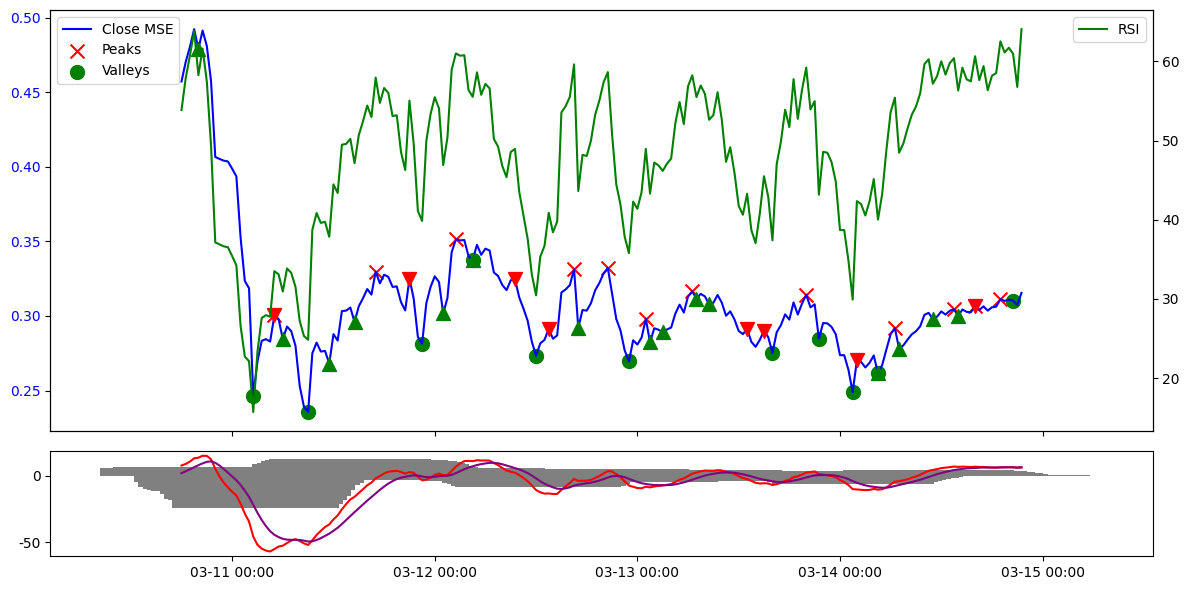

In [551]:

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
def plot_stock(df, n=100):
    plt.rcParams['font.sans-serif'] = ['SimHei','DejaVu Sans','Bitstream Vera Sans','Arial Serif','freeserif','sans-serif']
    plt.rcParams['axes.unicode_minus'] = False
    looksize =n
    look_df = df[-looksize:]
    tIndex = df.index[-looksize:]
    fig, (ax1, ax2) = plt.subplots(2,1,sharex=True,  figsize=(12,6),height_ratios=[4, 1])
    ax1.plot(tIndex, look_df['MSE'], color='blue', label='Close MSE')
#     ax1.plot(tIndex, look_df['ma_center'], color='blue', linestyle='--', label=f'MA{window_size}')
    ax3 = ax1.twinx()
    ax3.plot(tIndex, look_df['RSI'], color='green', label='RSI')   
       # 标记最终结果
    ax1.scatter(tIndex[look_df['final_peak']], look_df['MSE'][look_df['final_peak']], 
              color='red', marker='x', s=100, label='Peaks')
    ax1.scatter(tIndex[look_df['final_valley']], look_df['MSE'][look_df['final_valley']],
            color='green', marker='o', s=100, label='Valleys')
    ax1.scatter(look_df[look_df['top_divergence']==1].index[-15:], 
           look_df['MSE'][look_df['top_divergence']==1][-15:], 
           color='red', marker='v', s=100, zorder=2)
    
    ax1.scatter(look_df[look_df['bottom_divergence']==1].index[-15:], 
           look_df['MSE'][look_df['bottom_divergence']==1][-15:], 
           color='green', marker='^', s=100,zorder=2)
    ax1.tick_params(axis='y', labelcolor='blue')
    ax1.legend(loc='upper left')

    ax2.plot(tIndex, look_df['MACD'], color='red', label='MACD')
    ax2.plot(tIndex, look_df['Signal'], color='purple', label='Signal')
    ax2.bar(tIndex, look_df['Hist'], color='gray', label='Hist')

    ax1.xaxis.set_major_locator(mdates.AutoDateLocator())
    ax1.xaxis.set_major_formatter(mdates.DateFormatter("%m-%d %H:%M"))
    plt.legend()
    plt.tight_layout()
    plt.show()
plot_stock(data.dropna(), n=200)

In [552]:
from typing import Dict, Any
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, RobustScaler
from xgboost import XGBRegressor
def get_model_configs() -> Dict[str, Dict[str, Any]]:
    """统一管理模型配置"""
    return {
        # 'random_forest': {
        #     'pipeline': Pipeline([
        #         ('scaler', StandardScaler()),
        #         ('regressor', RandomForestRegressor())
        #     ]),
        #     'param_grid': {
        #         'regressor__n_estimators': [100, 200],
        #         'regressor__max_depth': [5, 8]
        #     }
        # },
        # 'xgb': {
        #     'pipeline': Pipeline([
        #         ('scaler', RobustScaler()),
        #         ('regressor', XGBRegressor(
        #             objective='reg:squarederror', 
        #             n_jobs=-1
        #         ))
        #     ]),
        #     'param_grid': {
        #         'regressor__learning_rate': [0.005, 0.01, 0.05],
        #         'regressor__max_depth': [3, 5, 7],
        #         'regressor__subsample': [0.6, 0.8],
        #         'regressor__colsample_bytree': [0.7, 0.9],
        #         'regressor__n_estimators': [200, 300]
        #     }
        # },
        'lstm': {
            'seq_length': 30,
            'params': {
                'units': 128,
                'dropout': 0.2,
                'learning_rate': 1e-3,
                'batch_size': 64,
                'epochs': 100
            }
        },
        # 'transformer': {
        #     'seq_length': 30,
        #     'params': {
        #         'd_model': 15,
        #         'num_heads': 3, #建议选择d_model的约数（例如d_model=15时可设3或5）
        #         'ff_dim': 60, #通常设为d_model的2-4倍
        #         'num_layers': 2,
        #         'dropout': 0.1,
        #         'learning_rate': 1e-4,
        #         'batch_size': 32,
        #         'epochs': 200
        #     }
        # }
    }

In [553]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, LayerNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import MultiHeadAttention, LayerNormalization, Dense

tf.config.list_physical_devices('GPU')
class TransformerEncoder(tf.keras.layers.Layer):
    def __init__(self, d_model, num_heads, ff_dim, dropout=0.1):
        super().__init__()
        self.attn = MultiHeadAttention(num_heads=num_heads, key_dim=d_model)
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(d_model)
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = tf.keras.layers.Dropout(dropout)
        self.dropout2 = tf.keras.layers.Dropout(dropout)

    def call(self, inputs, training=False):
        attn_output = self.attn(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, d_model):
        super().__init__()
        self.d_model = tf.cast(d_model, tf.float32)
        self.post_encoding = None
    def build(self, input_shape):
        # 在build阶段创建可训练参数
        position = tf.range(input_shape[1], dtype=tf.float32)[:, tf.newaxis]
        div_term = tf.exp(tf.range(0, self.d_model, 2, dtype=tf.float32) * 
                        (-tf.math.log(10000.0) / self.d_model))
        
        angle_rads = position * div_term
        # 初始化正弦和余弦编码
        sin = tf.sin(angle_rads)
        cos = tf.cos(angle_rads)
        # 动态填充以适应奇偶维度
        if self.d_model % 2 == 1:
            sin = tf.pad(sin, [[0,0], [0,1]])
        # 交错拼接正弦和余弦编码
        pos_encoding = tf.stack([sin, cos], axis=2)
        self.pos_encoding = tf.reshape(pos_encoding, [1, -1, self.d_model])    
    def call(self, inputs):
        # seq_len = tf.shape(inputs)[1]
        # position = tf.range(seq_len, dtype=tf.float32)[:, tf.newaxis]
        # div_term = tf.exp(tf.range(0, self.d_model, 2, dtype=tf.float32) * 
        #                 (-tf.math.log(10000.0) / self.d_model))
        
        # pe = tf.zeros((1, seq_len, tf.cast(self.d_model, tf.int32)))
        # pe = tf.Variable(pe)
        # pe[:, :, 0::2].assign(tf.sin(position * div_term))
        # pe[:, :, 1::2].assign(tf.cos(position * div_term))
        return inputs + self.pos_encoding[:, :tf.shape(inputs)[1], :]
def create_sequences(data, seq_length):
    """创建时间序列样本"""
    X, y = [], []
    for i in range(len(data)-seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

def build_lstm_model(input_shape, params):
    """构建LSTM模型"""
    model = Sequential([
        LSTM(params['units'], input_shape=input_shape, return_sequences=True),
        Dropout(params['dropout']),
        LSTM(params['units']),
        Dropout(params['dropout']),
        Dense(1)
    ])
    model.compile(
        optimizer=Adam(params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    return model

def build_transformer_model(input_shape, params):
    """构建Transformer模型"""
    inputs = tf.keras.Input(shape=input_shape)
    # 维度验证
    assert input_shape[-1] == params['d_model'], \
        f"特征维度{input_shape[-1]}与d_model{params['d_model']}不匹配"
    
    # 特征投影层
    x = tf.keras.layers.Dense(params['d_model'])(inputs)
    # 位置编码层
    x = PositionalEncoding(params['d_model'])(x)
    
    # # Transformer编码层
    for _ in range(params['num_layers']):
        x = TransformerEncoder(params['d_model'], params['num_heads'], params['ff_dim'])(x)
    
    # 全局平均池化 + 输出层
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    outputs = Dense(1)(x)
    
    model = tf.keras.Model(inputs, outputs)
    model.compile(
        optimizer=Adam(params['learning_rate']),
        loss='mse',
        metrics=['mae']
    )
    return model

class TimeSeriesModel(BaseEstimator):
    """统一时序模型接口"""
    def __init__(self, model_type='lstm',seq_length = 30, **params):
        self.model_type = model_type
        self.params = params
        self.model = None
        self.val_performance = {}
        self.performance = {}
        self.seq_length = seq_length

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.utils.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32,)

        ds = ds.map(self.split_window)
        return ds

    def fit(self, X, y):
        # 数据预处理
        seq_length = self.seq_length
        X_seq, y_seq = create_sequences(X.values, seq_length)
        print("X shape:", X_seq.shape, "Type:", X_seq.dtype)
        print("y shape:", y_seq.shape, "Type:", y_seq.dtype)
        # 构建模型
        if self.model_type == 'lstm':
            self.model = build_lstm_model((seq_length, X.shape[1]), self.params)
        elif self.model_type == 'transformer':
            self.model = build_transformer_model((seq_length, X.shape[1]), self.params)
        
        # # 训练
        early_stop = EarlyStopping(monitor='val_loss', patience=10)
        self.history = self.model.fit(
            X_seq, y_seq,
            batch_size=self.params['batch_size'],
            epochs=self.params['epochs'],
            validation_split=0.2,
            callbacks=[early_stop],
            verbose=0
        )

        # self.val_performance['Linear'] = self.model.evaluate(single_step_window.val)
        # self.performance['Linear'] = self.model.evaluate(single_step_window.test, verbose=0)
        return self
    
    def predict(self, X):
        return self.model.predict(X).flatten()

In [554]:
from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor,VotingRegressor
def train_models(X, y):
    """训练多个模型"""

    assert X.shape[0] == y.shape[0], "特征和目标数据长度不一致"
    tscv = TimeSeriesSplit(n_splits=5, test_size=30)
    model_configs = get_model_configs()
    results = {}
    for model_name, config in model_configs.items():
        # if model_name in ['lstm', 'transformer']:
        # 深度学习模型训练
        # 添加交叉验证逻辑
        cv_scores = []
        for train_index, test_index in tscv.split(X):
            X_train, X_test = X.iloc[train_index], X.iloc[test_index]
            y_train, y_test = y.iloc[train_index], y.iloc[test_index]
            model = TimeSeriesModel(model_name, config['seq_length'], **config['params'])
            model.fit(X_train, y_train)
            # score = model.model.evaluate(X_test, y_test, verbose=0)[1]
            evaluation = model.model.evaluate(X_test, y_test, verbose=0)
            score = evaluation[1] if len(evaluation)>1 else evaluation[0]
            cv_scores.append(score)
        results[model_name] = {
            'model': model,
            'history': model.history,
            'cv_score': np.mean(cv_scores)  # 添加交叉验证分数
        }
    ensemble_baseline = np.mean([results[model]['cv_score'] for model in results])
    ensemble = VotingRegressor(
        [(name, results['model']) for name, results in results.items()]
    )
    ensemble.baseline_score = ensemble_baseline  # 添加基准分数属性
    return ensemble

In [555]:
def create_features(data:pd.DataFrame, lookahead = 5):
    # 特征工程
    for lag in [1, 3, 5]:
        data[f'return_lag{lag}'] = data['close'].pct_change(lag)
    # 添加技术指标交叉信号
    data['MACD_cross'] = np.where(data['MACD'] > data['Signal'], 1, -1)
    data['BB_width'] = (data['UpperBB'] - data['LowerBB']) / data['MiddleBB']
    # 严格时序特征生成
    data['future_return'] = data['close'].pct_change(lookahead).shift(-lookahead -1)

    data['log_return'] = np.log(data['close']).diff()
    data['volatility_30'] = data['log_return'].rolling(30).std()
    # 新增时间序列特征
    # data['month'] = data.index.month
    # data['day_of_week'] = data.index.dayofweek

    # 特征选择
    selected_features = ['RSI', 'MACD','Signal', 'volatility_30',  'UpperBB', 'MiddleBB', 'LowerBB', 'BB_width',
                        'return_lag1', 'return_lag3', 'ma_center','final_peak', 'final_valley', 'top_divergence', 'bottom_divergence']
    data['return'] = data['close'].pct_change()
# ,'final_peak', 'final_valley', 'top_divergence', 'bottom_divergence'
    data.fillna(0, inplace=True)
    data['final_peak'] = data['final_peak'].astype(int)
    data['final_valley'] = data['final_valley'].astype(int)
    # data['top_divergence'] = data['top_divergence'].astype(int)
    # data['bottom_divergence'] = data['bottom_divergence'].astype(int)
    # 确保时间对齐
    data = data.dropna()
    
    return  data[selected_features], data['future_return']

In [556]:
from sklearn.model_selection import cross_val_score, TimeSeriesSplit
features, target = create_features(data)
# print("Features types:\n", features.dtypes)
# print("Target type:", target.dtype)
"""训练模型"""
ensemble = train_models(features, target)

current_score = cross_val_score(ensemble, features, target, cv=5).mean()
print(f"Current score: {current_score}")

/var/folders/5n/8x0dgwn903d3y5tfv1y93xj00000gn/T/ipykernel_8372/1476087825.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'return_lag{lag}'] = data['close'].pct_change(lag)
/var/folders/5n/8x0dgwn903d3y5tfv1y93xj00000gn/T/ipykernel_8372/1476087825.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data[f'return_lag{lag}'] = data['close'].pct_change(lag)
/var/folders/5n/8x0dgwn903d3y5tfv1y93xj00000gn/T/ipykernel_8372/1476087825.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy 

X shape: (129205, 30, 15) Type: float64
y shape: (129205, 15) Type: float64


/opt/anaconda3/envs/python312/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


ValueError: Exception encountered when calling Sequential.call().

[1mCannot take the length of shape with unknown rank.[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
  • training=False
  • mask=None